# Denoising and Inpainting with Dictionary Learning

This notebook implements denoising and inpainting using a pre-trained dictionary, evaluating performance at different SNR levels. The implementation uses the Orthogonal Matching Pursuit (OMP) algorithm for sparse coding.

In [1]:
###############################################################################
# DENOISING/INPAINTING SCRIPT                                                 #
###############################################################################
# This script implements denoising and inpainting using a pre-trained 
# dictionary, evaluating performance at different SNR levels.
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import scipy.io
from skimage.util.shape import view_as_blocks
from skimage.util import img_as_float

# ------------------ PARAMETERS ----------------------------------------
block_size = 8  # patch dimension (pixels)
T0 = 8  # sparsity per block
epsilon = 0  # residual threshold (0 → off)
gOMP_N = 1  # =1 → OMP, >1 → GenOMP batch size
SNR_levels = [0, 20, 50, 100]  # SNR levels in dB
np.random.seed(0)  # reproducibility seed

## Loading Pre-trained Dictionary

Load the dictionary matrices (D.mat) from the previous exercise.

In [2]:
# ------------------ LOAD PRETRAINED DICTIONARY ------------------------
D = scipy.io.loadmat('D.mat')['D']  # Dictionary from previous exercise
print(f"Loaded pre-trained dictionary with {D.shape[1]} atoms.")

Loaded pre-trained dictionary with 512 atoms.


## Dataset Paths

Define and load the paths to test images.

In [3]:
# ------------------ DATASET PATHS ------------------------------------
test_dir = os.path.join('dataset', 'test')
img_ext = ['*.png', '*.jpg', '*.bmp']

te_files = []
for ext in img_ext:
    te_files.extend(glob.glob(os.path.join(test_dir, ext)))
assert len(te_files) > 0, 'No test images found.'
print(f"Found {len(te_files)} test images.")

Found 7 test images.


## Helper Functions

Define helper functions for block extraction, image assembly, and the Generic Orthogonal Matching Pursuit (GenOMP) algorithm.

In [4]:
def extract_blocks(image):
    """Extract non-overlapping blocks from image"""
    # Ensure image dimensions are multiples of block_size
    h, w = image.shape
    h_blocks = h // block_size
    w_blocks = w // block_size

    # Crop image if needed
    image = image[:h_blocks * block_size, :w_blocks * block_size]

    # Extract blocks
    blocks = view_as_blocks(image, (block_size, block_size))
    blocks = blocks.reshape(-1, block_size * block_size).T

    return blocks, (h_blocks * block_size, w_blocks * block_size)

In [5]:
def assemble_image(blocks, img_size):
    """Reconstruct image from blocks"""
    h, w = img_size
    h_blocks = h // block_size
    w_blocks = w // block_size

    # Reshape blocks to match original dimensions
    blocks = blocks.T.reshape(h_blocks, w_blocks, block_size, block_size)

    # Initialize output image
    output = np.zeros((h, w))

    # Fill in blocks
    for i in range(h_blocks):
        for j in range(w_blocks):
            output[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size] = blocks[i, j]

    return output

In [6]:
def GenOMP(D, y, T0, epsilon=0, N=1):
    """Generic Orthogonal Matching Pursuit algorithm"""
    n, K = D.shape
    x = np.zeros(K)
    r = y.copy()
    support = []

    # Continue until T0 atoms are selected or residual is small enough
    while len(support) < T0 and (epsilon == 0 or np.linalg.norm(r) > epsilon):
        # Compute correlations
        correlations = np.abs(D.T @ r)

        # Find N atoms with highest correlation
        if N == 1:
            idx = np.argmax(correlations)
            new_indices = [idx]
        else:
            # Get indices of N highest correlations not already in support
            available_indices = np.setdiff1d(np.arange(K), support)
            if len(available_indices) == 0:
                break

            avail_corr = correlations[available_indices]
            N = min(N, len(available_indices))
            top_N_indices = np.argsort(avail_corr)[-N:]
            new_indices = [available_indices[i] for i in top_N_indices]

        # Add to support
        support.extend(new_indices)

        # Solve least squares problem
        D_support = D[:, support]
        x_support = np.linalg.lstsq(D_support, y, rcond=None)[0]

        # Update residual
        r = y - D_support @ x_support

    # Fill in sparse code
    x[support] = x_support
    return x

## Denoising Experiment

In this section, we run the denoising experiment on the test images. For each image, we add noise at different SNR levels, then denoise using the dictionary-based approach.

In [7]:
print('Running denoising experiment...')

# Storage for results
num_images = len(te_files)
mse_denoising = np.zeros((num_images, len(SNR_levels)))
psnr_denoising = np.zeros((num_images, len(SNR_levels)))

Running denoising experiment...


Image 0 (parrot.jpg), SNR=0dB: MSE=0.042451, PSNR=13.72dB
Image 0 (parrot.jpg), SNR=20dB: MSE=0.000615, PSNR=32.11dB
Image 0 (parrot.jpg), SNR=50dB: MSE=0.000096, PSNR=40.16dB
Image 0 (parrot.jpg), SNR=100dB: MSE=0.000096, PSNR=40.18dB
Image 1 (cat_unknown.jpg), SNR=0dB: MSE=0.032074, PSNR=14.94dB
Image 1 (cat_unknown.jpg), SNR=20dB: MSE=0.000859, PSNR=30.66dB
Image 1 (cat_unknown.jpg), SNR=50dB: MSE=0.000469, PSNR=33.29dB
Image 1 (cat_unknown.jpg), SNR=100dB: MSE=0.000469, PSNR=33.29dB
Image 2 (cat_known.jpg), SNR=0dB: MSE=0.009877, PSNR=20.05dB
Image 2 (cat_known.jpg), SNR=20dB: MSE=0.000325, PSNR=34.88dB
Image 2 (cat_known.jpg), SNR=50dB: MSE=0.000201, PSNR=36.96dB
Image 2 (cat_known.jpg), SNR=100dB: MSE=0.000201, PSNR=36.96dB
Image 3 (keanu.jpg), SNR=0dB: MSE=0.009581, PSNR=20.19dB
Image 3 (keanu.jpg), SNR=20dB: MSE=0.000328, PSNR=34.84dB
Image 3 (keanu.jpg), SNR=50dB: MSE=0.000229, PSNR=36.40dB
Image 3 (keanu.jpg), SNR=100dB: MSE=0.000229, PSNR=36.41dB
Image 4 (field.jpg), SNR=0dB

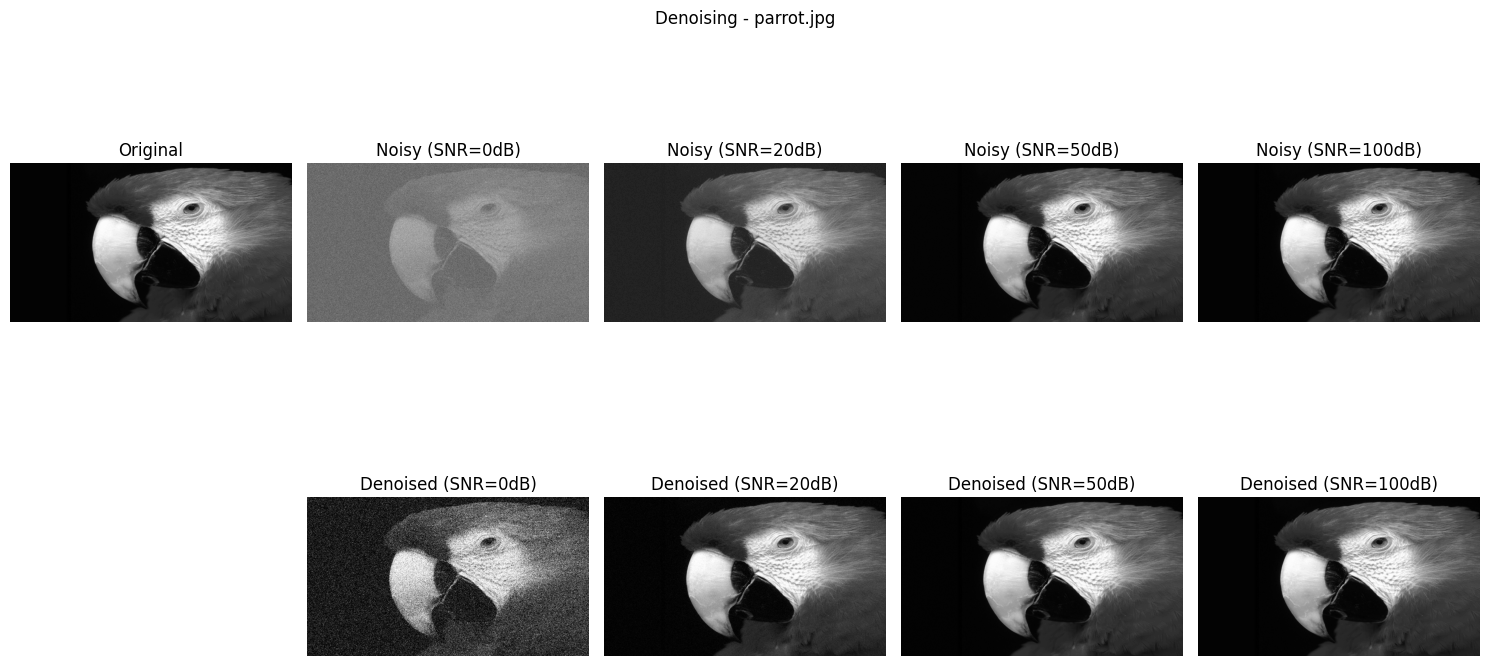

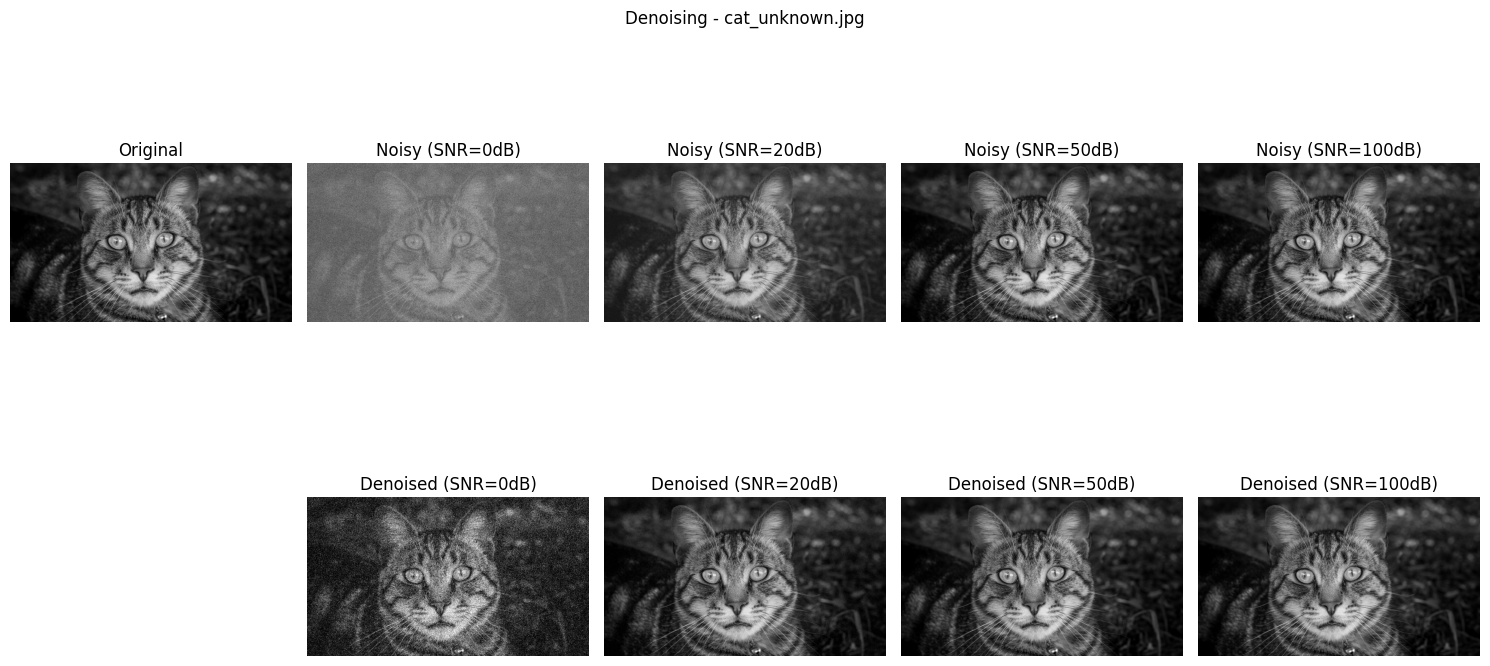

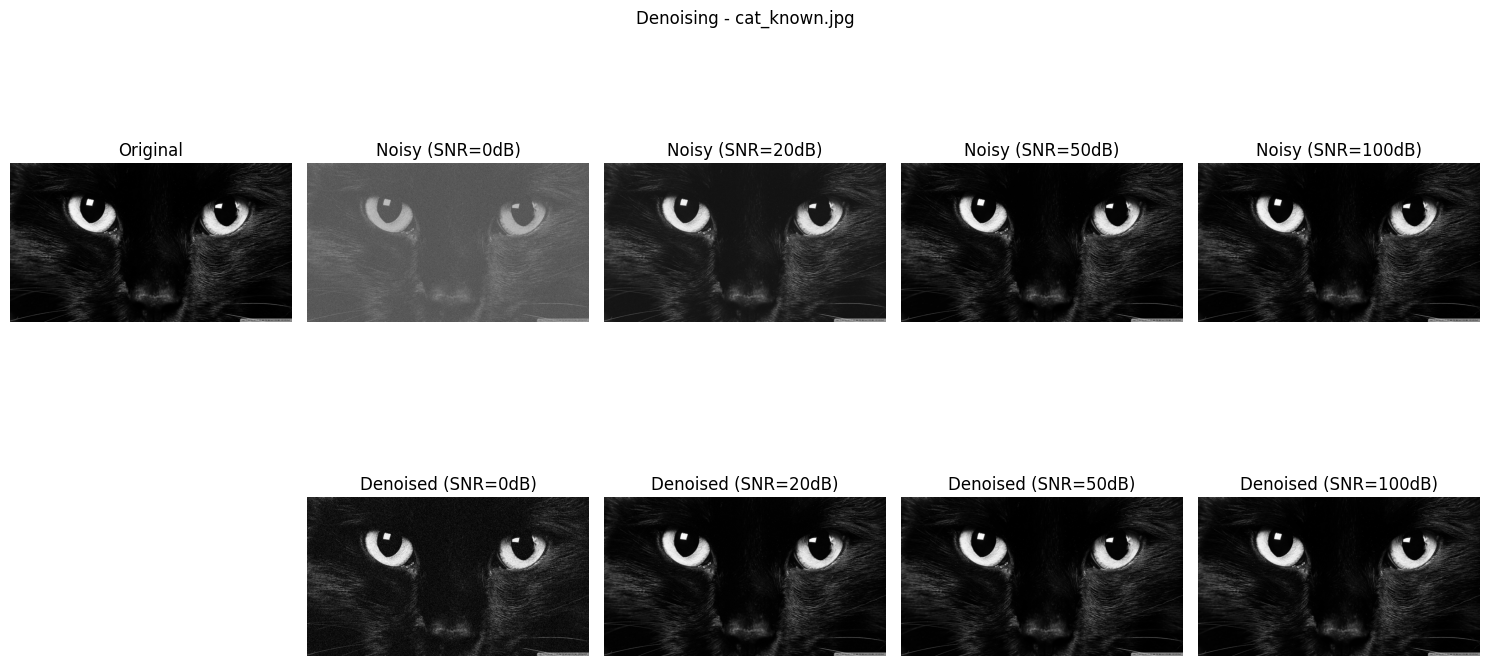

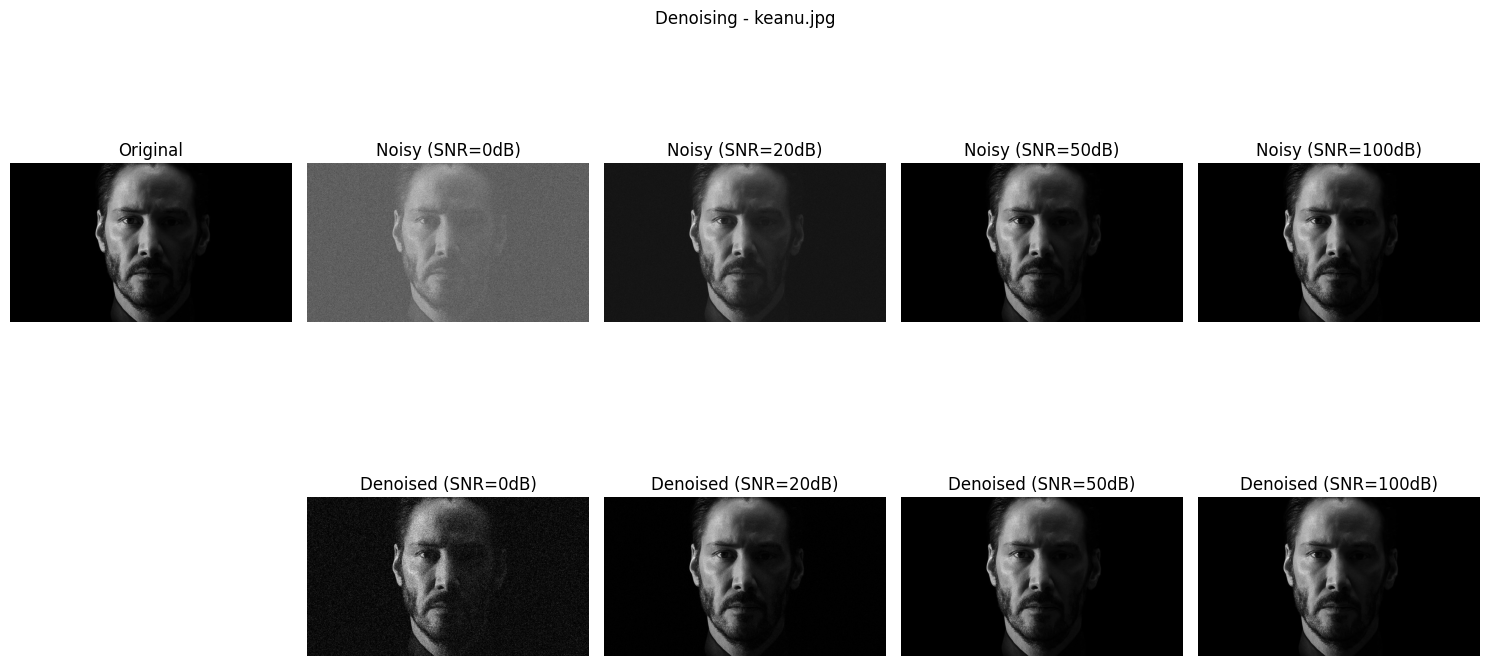

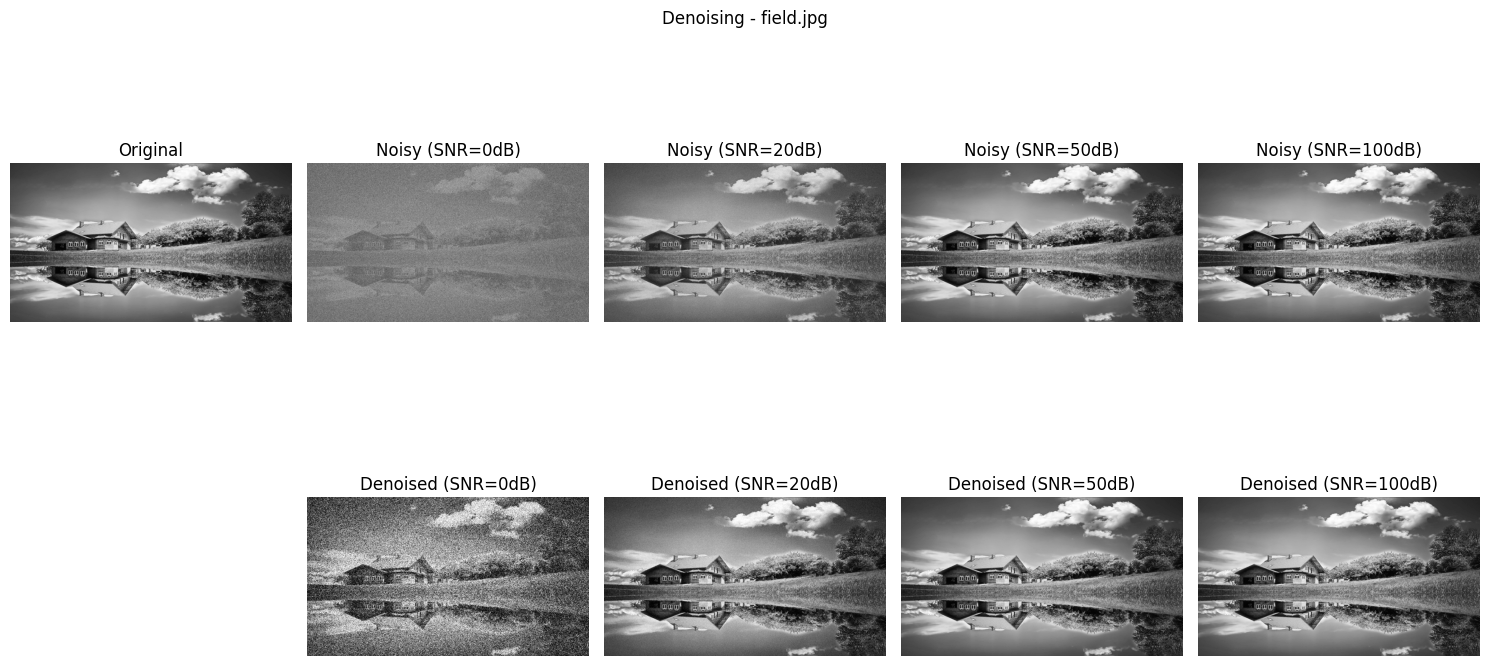

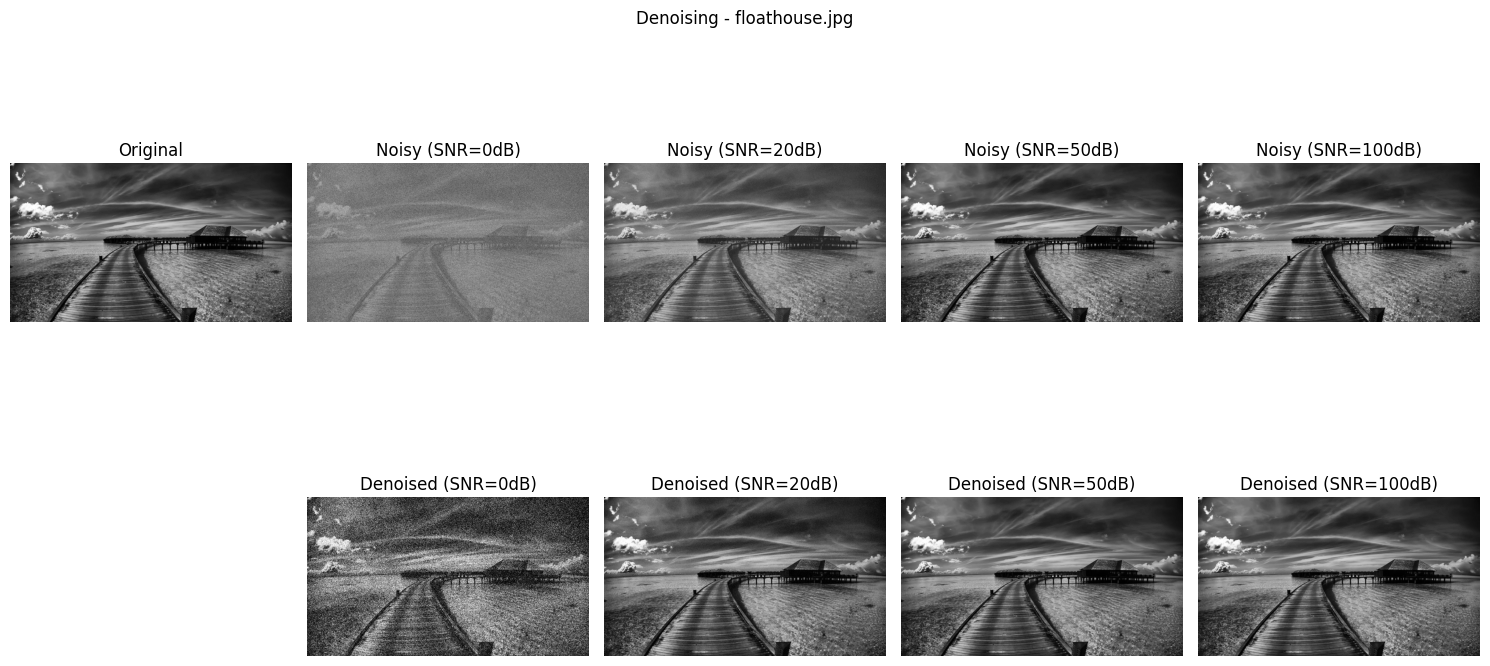

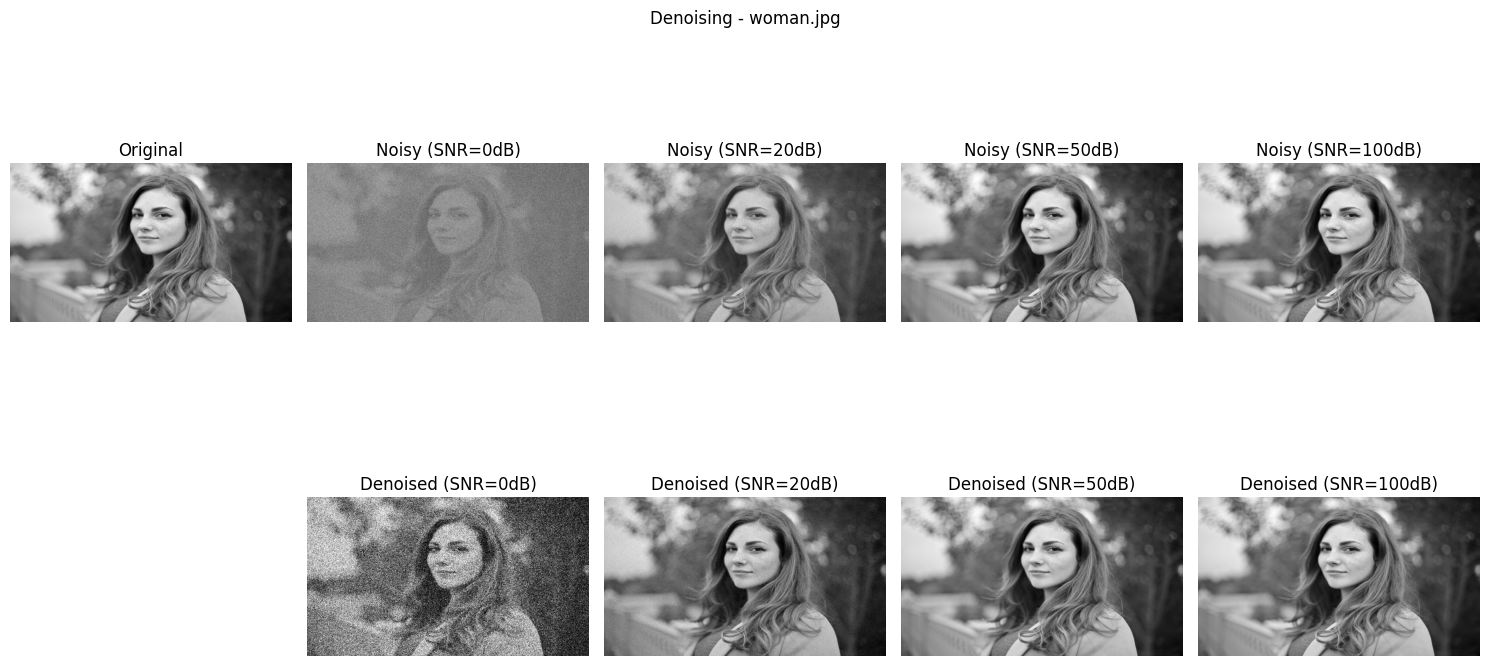

In [8]:
# For each test image
for i in range(num_images):
    # Load and convert to grayscale if needed
    img_path = te_files[i]
    img_name = os.path.basename(img_path)
    I_orig = img_as_float(np.array(Image.open(img_path).convert('L')))
    h, w = I_orig.shape

    # Create a figure for this image
    plt.figure(figsize=(15, 8))
    plt.suptitle(f'Denoising - {img_name}')

    # Show original image
    plt.subplot(2, len(SNR_levels) + 1, 1)
    plt.imshow(I_orig, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Test at different SNR levels
    for s, SNR in enumerate(SNR_levels):
        # Add noise according to SNR
        signal_power = np.mean(I_orig ** 2)
        noise_power = signal_power / (10 ** (SNR / 10))
        noise = np.sqrt(noise_power) * np.random.randn(*I_orig.shape)
        I_noisy = I_orig + noise

        # Show noisy image
        plt.subplot(2, len(SNR_levels) + 1, s + 2)
        plt.imshow(I_noisy, cmap='gray')
        plt.title(f'Noisy (SNR={SNR}dB)')
        plt.axis('off')

        # Extract blocks
        Blks, cropped_size = extract_blocks(I_noisy)

        # Process each block using GenOMP/OMP
        X = np.zeros((D.shape[1], Blks.shape[1]))
        for b in range(Blks.shape[1]):
            X[:, b] = GenOMP(D, Blks[:, b], T0, epsilon, gOMP_N)

        # Reconstruct image
        Rblks = D @ X
        I_denoised = assemble_image(Rblks, cropped_size)
        I_denoised = np.clip(I_denoised, 0, 1)  # clip to [0,1]

        # Show denoised image
        plt.subplot(2, len(SNR_levels) + 1, len(SNR_levels) + 2 + s + 1)
        plt.imshow(I_denoised, cmap='gray')
        plt.title(f'Denoised (SNR={SNR}dB)')
        plt.axis('off')

        # Calculate metrics
        cropped_orig = I_orig[:cropped_size[0], :cropped_size[1]]
        mse_denoising[i, s] = np.mean((I_denoised - cropped_orig) ** 2)
        psnr_denoising[i, s] = 10 * np.log10(1 / mse_denoising[i, s])

        print(f'Image {i} ({img_name}), SNR={SNR}dB: MSE={mse_denoising[i, s]:.6f}, PSNR={psnr_denoising[i, s]:.2f}dB')

    # Save figure
    plt.tight_layout()
    plt.savefig(f'denoising_image{i}.png')

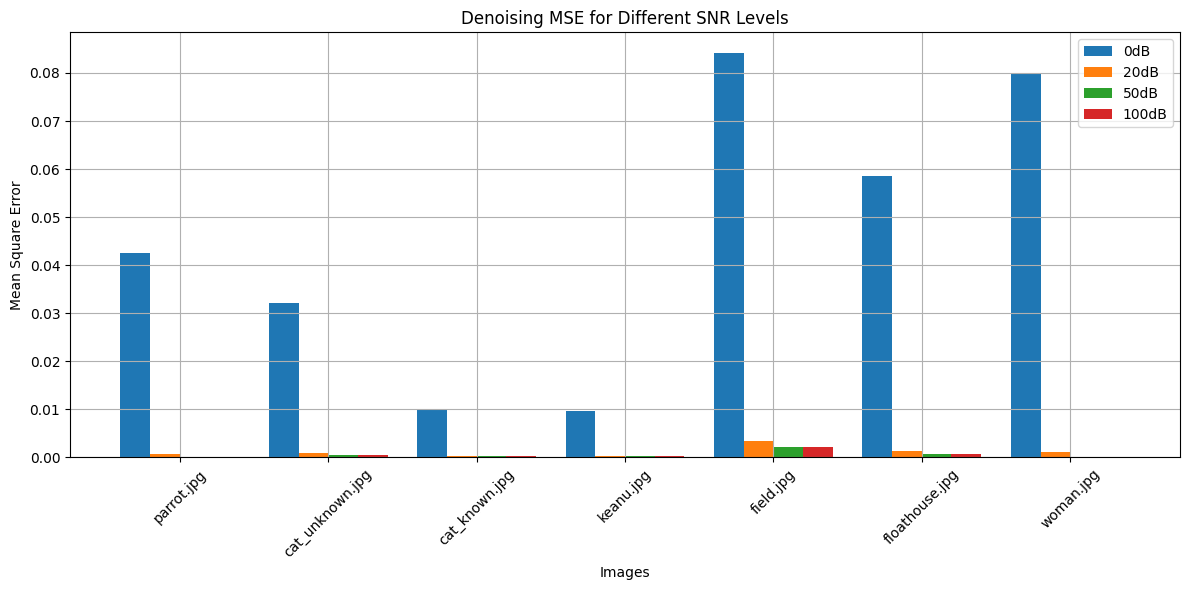

In [9]:
# Plot MSE results for denoising - Fixed bar plot
plt.figure(figsize=(12, 6))
x = np.arange(num_images)
width = 0.2  # width of bars
for s in range(len(SNR_levels)):
    plt.bar(x + s * width, mse_denoising[:, s], width, label=f'{SNR_levels[s]}dB')

plt.xlabel('Images')
plt.ylabel('Mean Square Error')
plt.title('Denoising MSE for Different SNR Levels')
plt.xticks(x + width * (len(SNR_levels) - 1) / 2, [os.path.basename(f) for f in te_files], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('denoising_mse.png')

## Inpainting Experiment

In this section, we run the inpainting experiment on the test images. For each image, we remove pixels at different percentages, then inpaint using the dictionary-based approach.

In [10]:
print('\nRunning inpainting experiment...')

# Storage for inpainting results
mse_inpainting = np.zeros((num_images, len(SNR_levels)))
psnr_inpainting = np.zeros((num_images, len(SNR_levels)))


Running inpainting experiment...


Image 0 (parrot.jpg), Missing=90%: MSE=0.107293, PSNR=9.69dB
Image 0 (parrot.jpg), Missing=50%: MSE=0.047589, PSNR=13.22dB
Image 0 (parrot.jpg), Missing=20%: MSE=0.015738, PSNR=18.03dB
Image 0 (parrot.jpg), Missing=10%: MSE=0.007170, PSNR=21.45dB
Image 1 (cat_unknown.jpg), Missing=90%: MSE=0.071272, PSNR=11.47dB
Image 1 (cat_unknown.jpg), Missing=50%: MSE=0.031746, PSNR=14.98dB
Image 1 (cat_unknown.jpg), Missing=20%: MSE=0.010950, PSNR=19.61dB
Image 1 (cat_unknown.jpg), Missing=10%: MSE=0.005282, PSNR=22.77dB
Image 2 (cat_known.jpg), Missing=90%: MSE=0.026095, PSNR=15.83dB
Image 2 (cat_known.jpg), Missing=50%: MSE=0.011666, PSNR=19.33dB
Image 2 (cat_known.jpg), Missing=20%: MSE=0.003941, PSNR=24.04dB
Image 2 (cat_known.jpg), Missing=10%: MSE=0.001875, PSNR=27.27dB
Image 3 (keanu.jpg), Missing=90%: MSE=0.025942, PSNR=15.86dB
Image 3 (keanu.jpg), Missing=50%: MSE=0.011606, PSNR=19.35dB
Image 3 (keanu.jpg), Missing=20%: MSE=0.003983, PSNR=24.00dB
Image 3 (keanu.jpg), Missing=10%: MSE=0.00

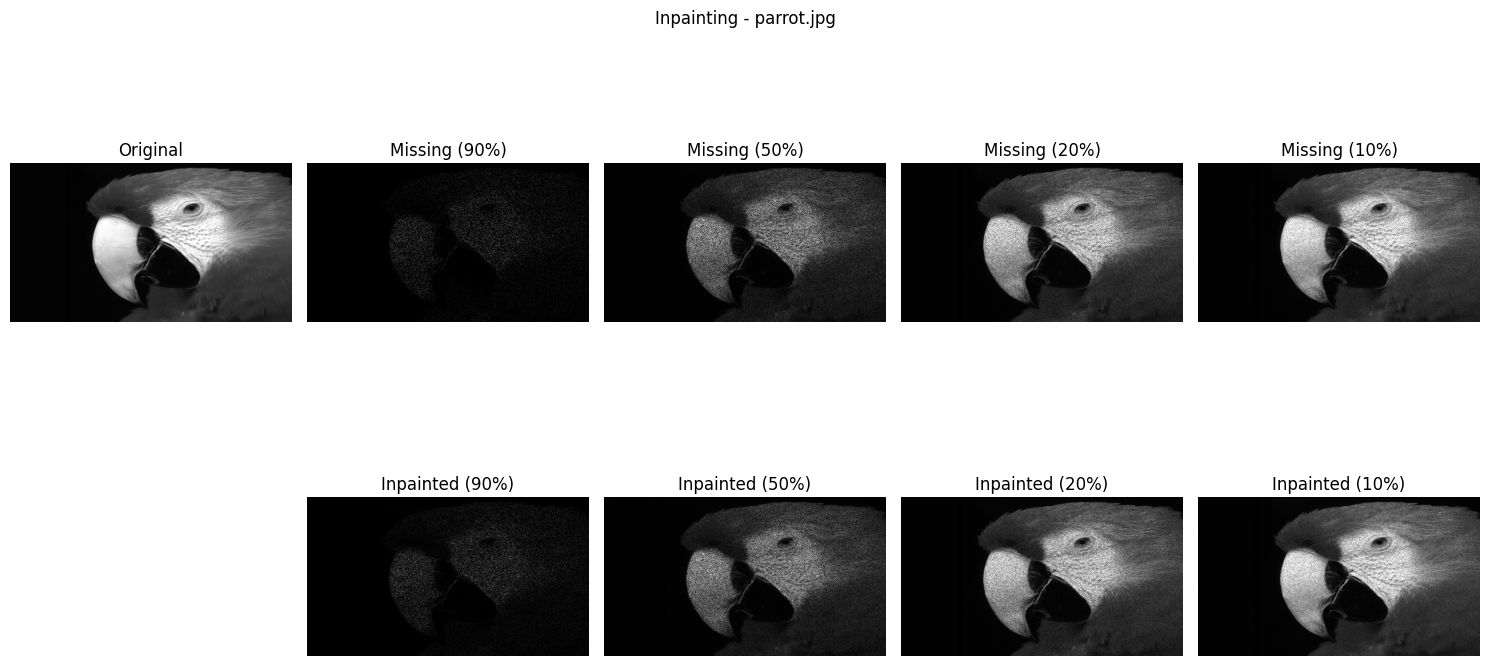

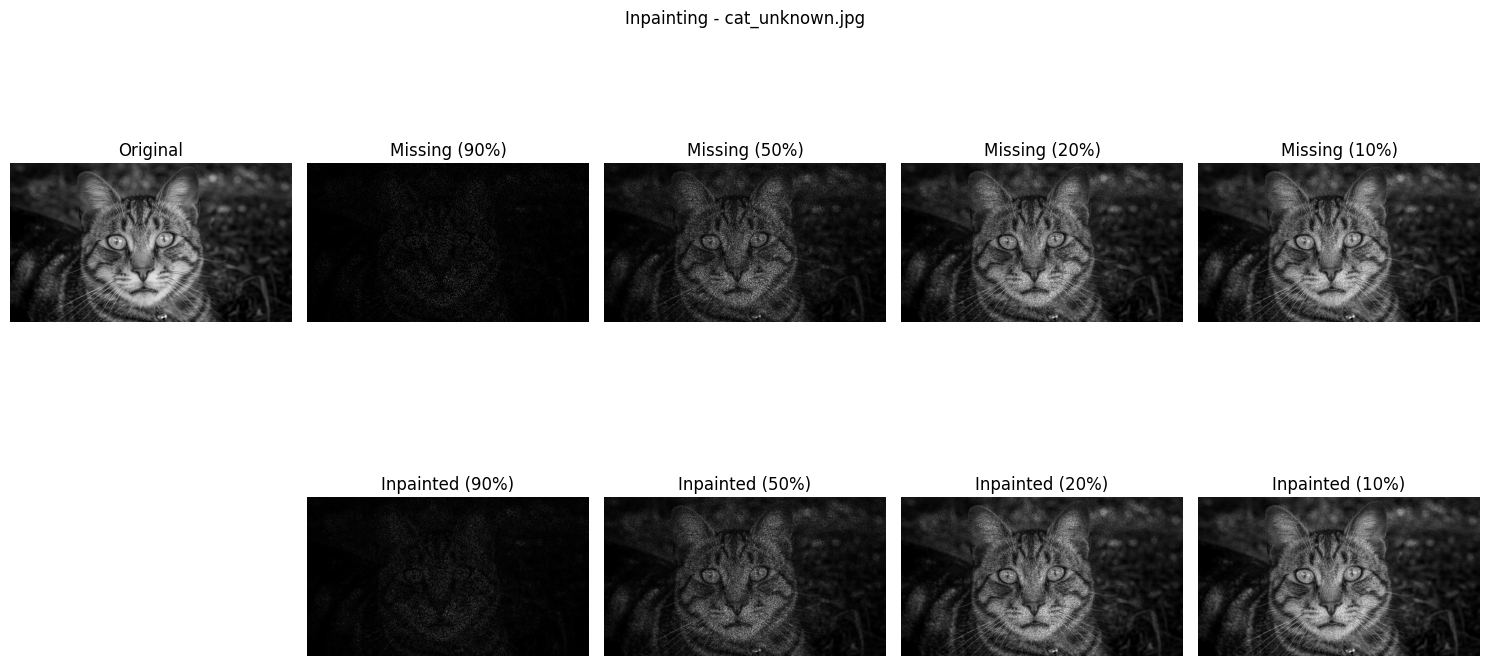

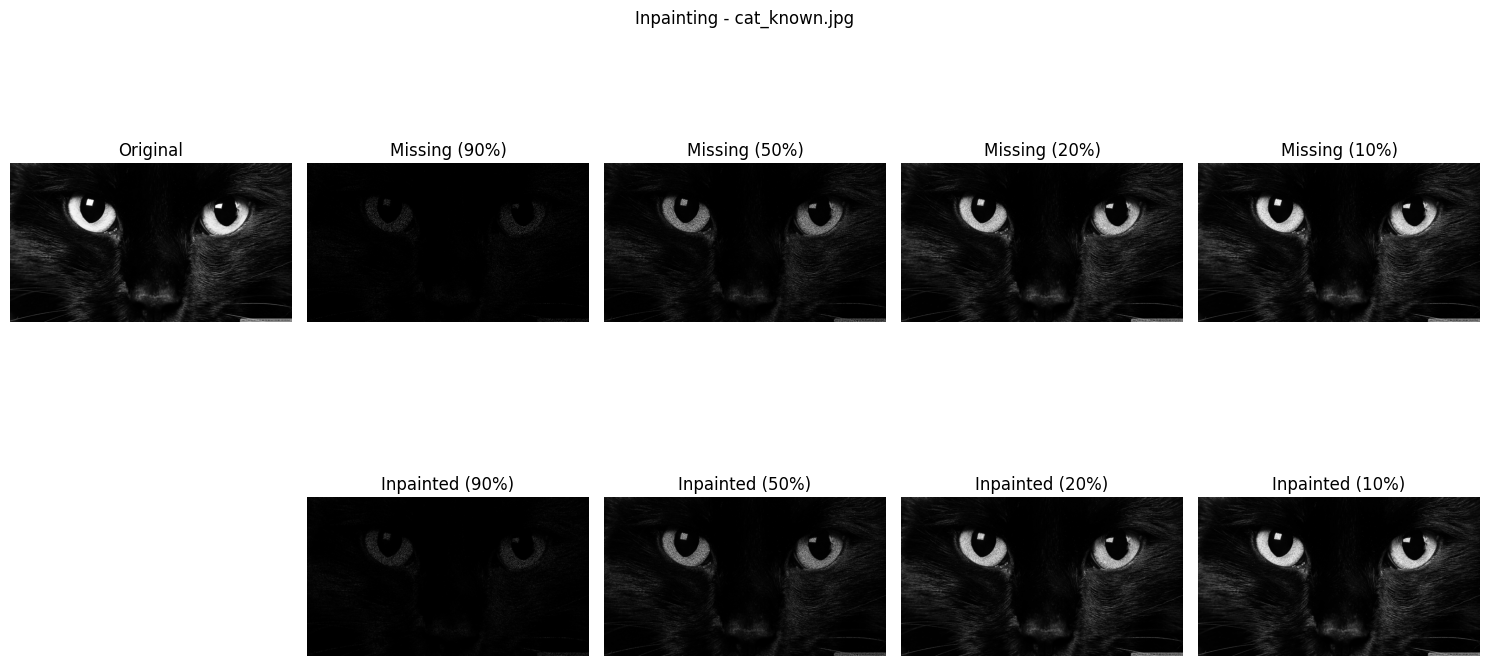

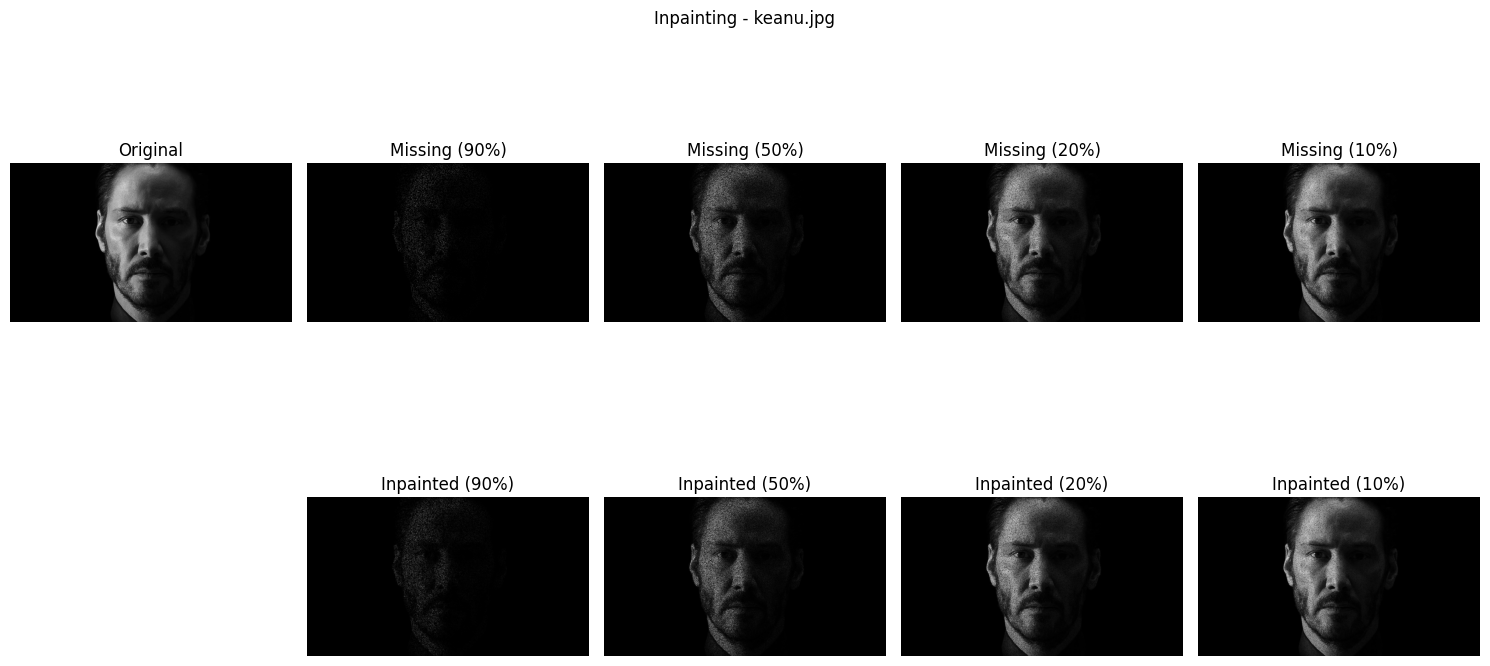

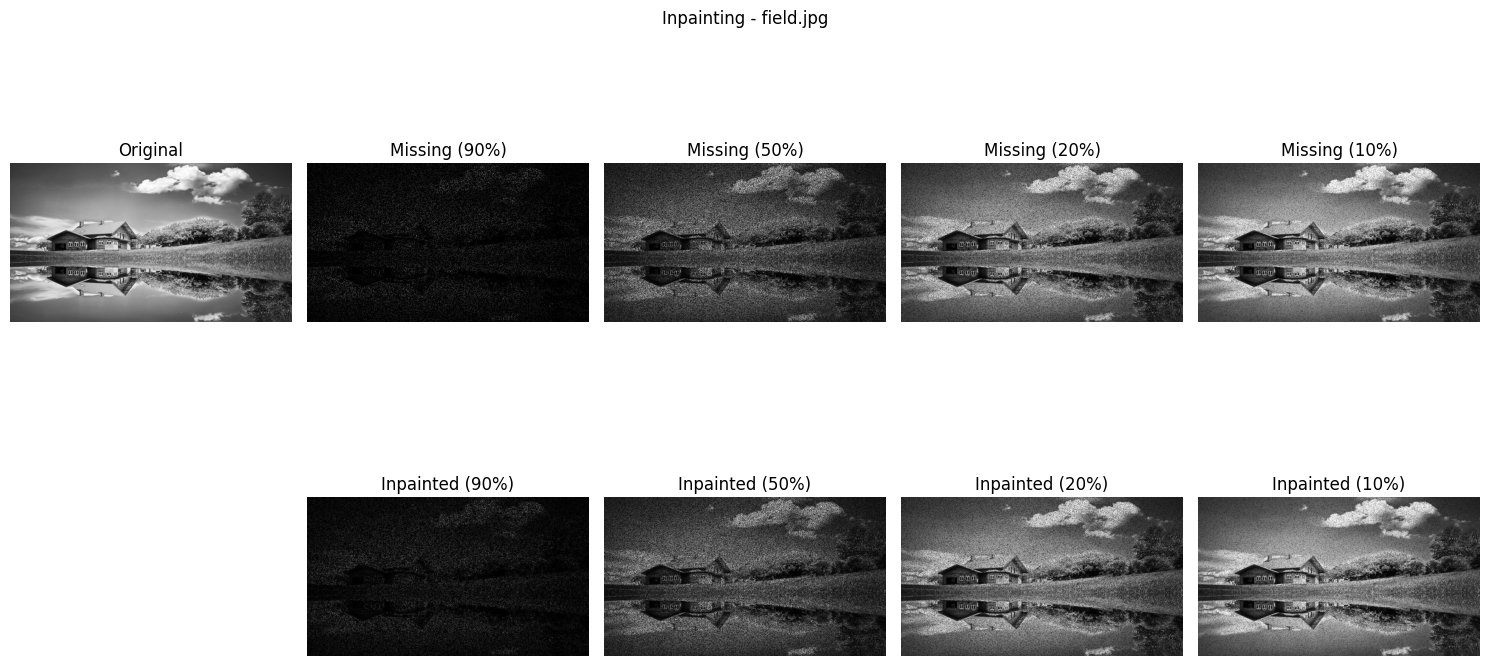

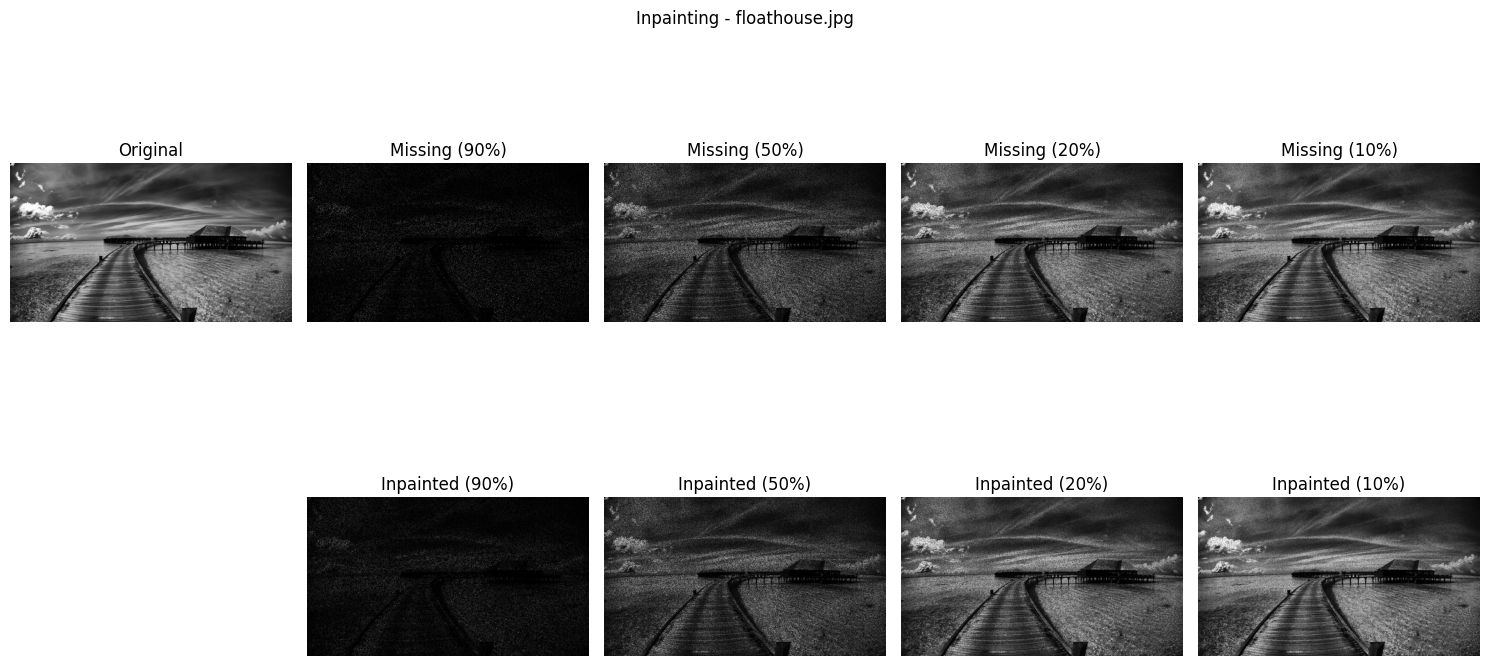

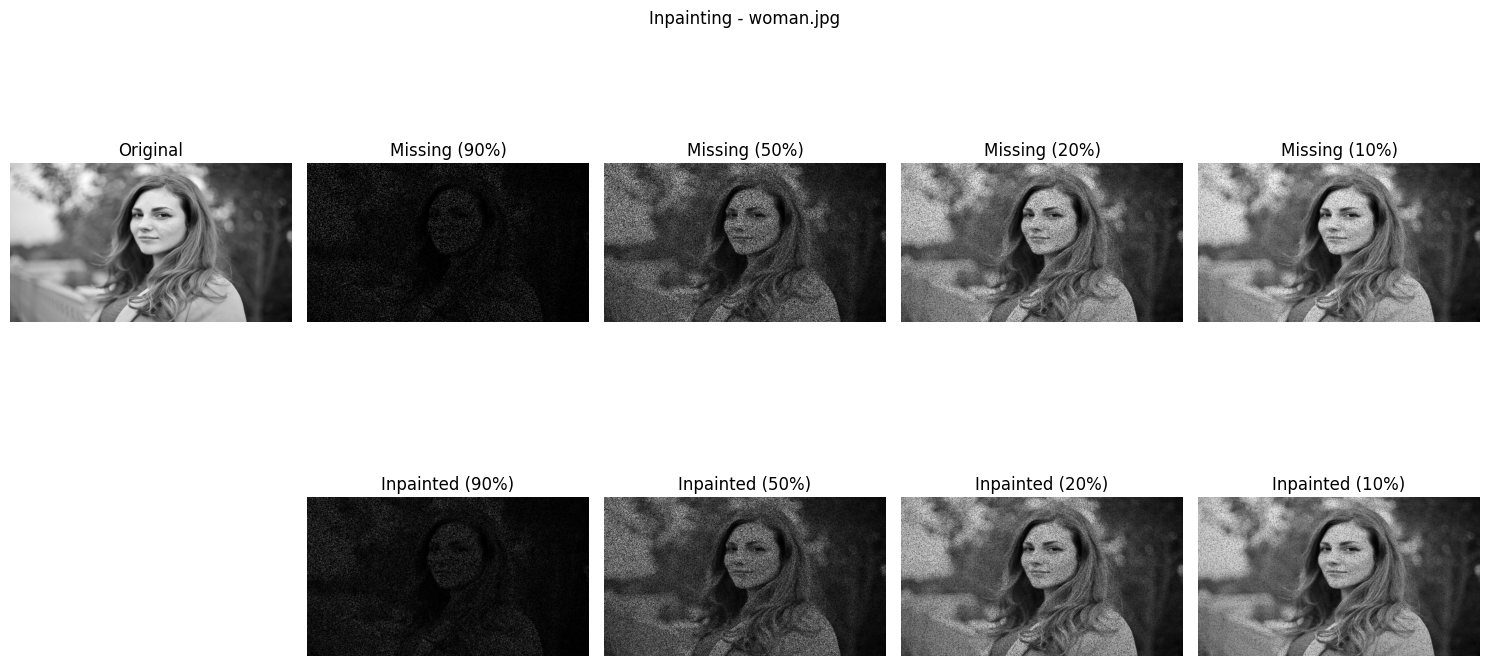

In [11]:
# For each test image
for i in range(num_images):
    # Load and convert to grayscale if needed
    img_path = te_files[i]
    img_name = os.path.basename(img_path)
    I_orig = img_as_float(np.array(Image.open(img_path).convert('L')))
    h, w = I_orig.shape

    # Create a figure for this image
    plt.figure(figsize=(15, 8))
    plt.suptitle(f'Inpainting - {img_name}')

    # Show original image
    plt.subplot(2, len(SNR_levels) + 1, 1)
    plt.imshow(I_orig, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Define percentage of pixels to remove based on SNR
    # Higher SNR = fewer pixels removed
    missing_percentages = [90, 50, 20, 10]  # Corresponding to SNR levels

    # Test at different SNR-equivalent levels
    for s, SNR in enumerate(SNR_levels):
        missing_pct = missing_percentages[s]

        # Create a binary mask with uniform distribution
        mask = np.random.rand(*I_orig.shape) > (missing_pct / 100)
        I_missing = I_orig * mask

        # Show image with missing pixels
        plt.subplot(2, len(SNR_levels) + 1, s + 2)
        plt.imshow(I_missing, cmap='gray')
        plt.title(f'Missing ({missing_pct}%)')
        plt.axis('off')

        # Extract blocks
        Blks, cropped_size = extract_blocks(I_missing)

        # Process each block using GenOMP/OMP
        X = np.zeros((D.shape[1], Blks.shape[1]))
        for b in range(Blks.shape[1]):
            X[:, b] = GenOMP(D, Blks[:, b], T0, epsilon, gOMP_N)

        # Reconstruct image
        Rblks = D @ X
        I_inpainted = assemble_image(Rblks, cropped_size)
        I_inpainted = np.clip(I_inpainted, 0, 1)  # clip to [0,1]

        # Show inpainted image
        plt.subplot(2, len(SNR_levels) + 1, len(SNR_levels) + 2 + s + 1)
        plt.imshow(I_inpainted, cmap='gray')
        plt.title(f'Inpainted ({missing_pct}%)')
        plt.axis('off')

        # Calculate metrics
        cropped_orig = I_orig[:cropped_size[0], :cropped_size[1]]
        mse_inpainting[i, s] = np.mean((I_inpainted - cropped_orig) ** 2)
        psnr_inpainting[i, s] = 10 * np.log10(1 / mse_inpainting[i, s])

        print(
            f'Image {i} ({img_name}), Missing={missing_pct}%: MSE={mse_inpainting[i, s]:.6f}, PSNR={psnr_inpainting[i, s]:.2f}dB')

    # Save figure
    plt.tight_layout()
    plt.savefig(f'inpainting_image{i}.png')

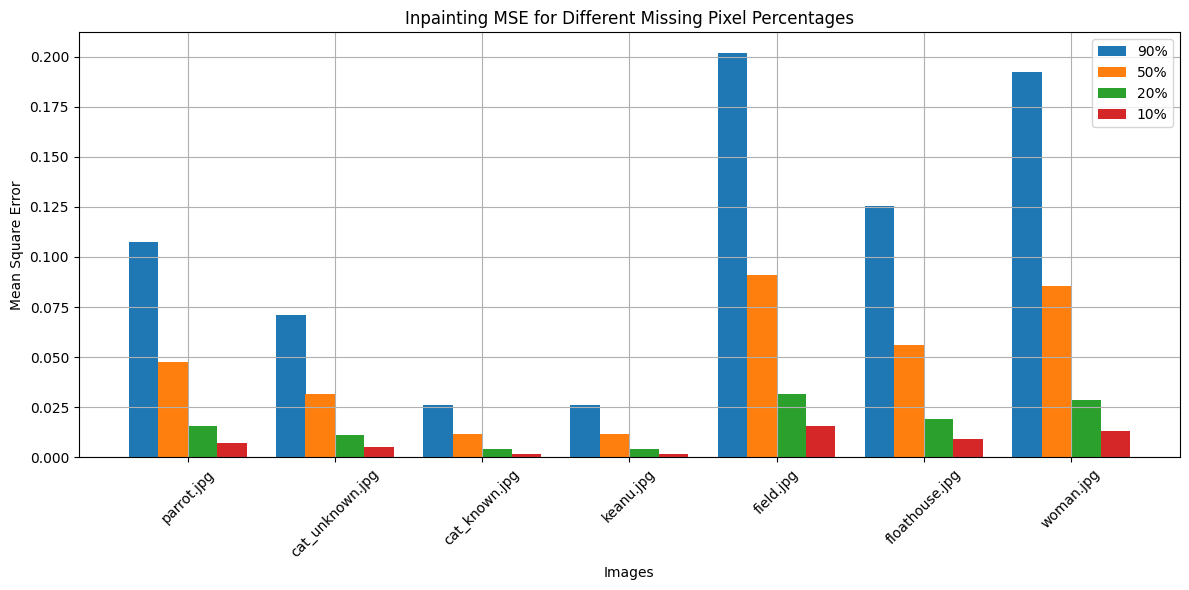

In [12]:
# Plot MSE results for inpainting - Fixed bar plot
plt.figure(figsize=(12, 6))
x = np.arange(num_images)
width = 0.2  # width of bars
for s in range(len(SNR_levels)):
    plt.bar(x + s * width, mse_inpainting[:, s], width, label=f'{missing_percentages[s]}%')

plt.xlabel('Images')
plt.ylabel('Mean Square Error')
plt.title('Inpainting MSE for Different Missing Pixel Percentages')
plt.xticks(x + width * (len(SNR_levels) - 1) / 2, [os.path.basename(f) for f in te_files], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('inpainting_mse.png')

## Save Results

Save the denoising and inpainting results for further analysis.

In [13]:
# ------------------ SAVE RESULTS -------------------------------------
np.savez('denoising_results.npz', mse_denoising=mse_denoising, psnr_denoising=psnr_denoising, SNR_levels=SNR_levels)
np.savez('inpainting_results.npz', mse_inpainting=mse_inpainting, psnr_inpainting=psnr_inpainting,
         missing_percentages=missing_percentages)

print('Experiments completed and results saved.')

Experiments completed and results saved.


## Denoise/Inpaint Algorithm Function

This function implements the core denoising/inpainting algorithm as specified in the assignment.

In [14]:
def denoise_inpaint_algorithm(D, Y, T0, epsilon=0, N=1):
    """
    Implements the denoising/inpainting algorithm as specified in the assignment.

    Input:
      D        : (n×K) dictionary with unit-norm columns
      Y        : (n×Nsig) input signals (possibly noisy or with missing values)
      T0       : target sparsity level passed to GenOMP
      epsilon  : residual threshold passed to GenOMP
      N        : (optional) number of atoms per GenOMP iteration

    Output:
      Y_star   - reconstructed signals
    """
    n, K = D.shape
    n, Nsig = Y.shape
    X = np.zeros((K, Nsig))

    # -------- Sparse coding of each signal column --------
    for i in range(Nsig):
        X[:, i] = GenOMP(D, Y[:, i], T0, epsilon, N)

    # -------- Reconstruction from sparse codes --------
    Y_star = D @ X

    return Y_star